__Vu H. Chu-Le__

___

# Building model

In this model, there is one variable that we observe: the price for a product $i$ at a brand of grocery store $j$ at a specific location $k$, which we will notate as $p_{ijk}$. This price is calculated from the base price for product $i$ ($b_i$) as well as the multipliers for store brand $j$ ($s_j$) and location $k$ ($l_k$). From this we can draw a primary factor graph as shown below.

![Graph 1](https://drive.google.com/uc?export=view&id=1jBFpE3VyqcQNlNaHERdwFSYNEe0t5clL)

_Fig 1. Primary factor graph for price $p_{ijk}$ from base price $b_i$ and the multipliers $s_j$ and $l_k$_

Next, we need to choose a prior and find the posterior for each of the variables $b_i$, $s_j$, and $l_k$. Each product, store brand, and location would be independently sampled from its own distribution. All of these variables must be positive since price cannot be negative. We also assume that they are continuous variables. Technically, since $b$ is also a price and must be positive, $s$ and $k$ can both be negative and $p$ would still be positive, but that would not make sense so we will ignore this possibility.

In the code cell below we plot the histogram of prices for each product to visually examine the shape of their distributions.

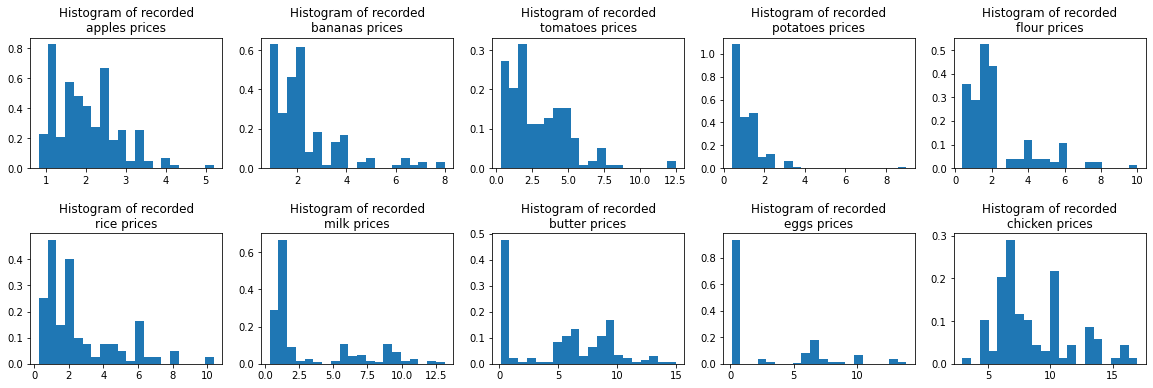

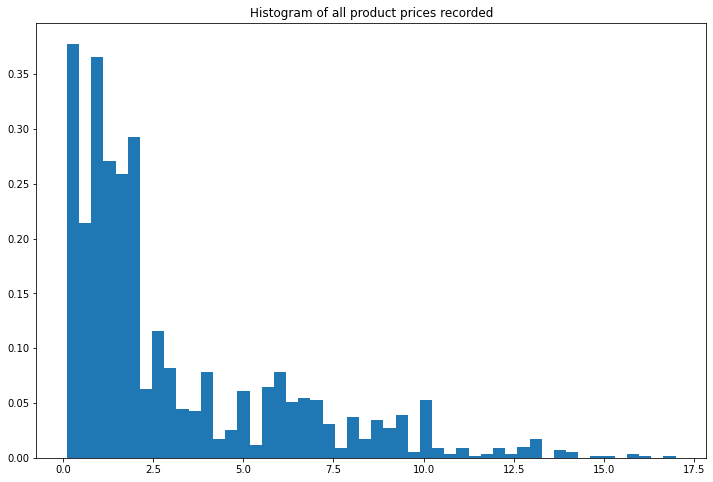

In [2]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
df = pd.read_csv("processed_data.csv")
products = df['variable'].unique()
plt.figure(figsize=(20, 6))
groups = df.groupby('variable')
for i, product in enumerate(products):
    price = groups.get_group(product)['Price']
    plt.subplot(2, 5, i+1)
    plt.hist(price, bins=20, density=True)
    plt.title(f'Histogram of recorded\n{product.lower()} prices')
plt.subplots_adjust(hspace=0.5)
plt.show()

plt.figure(figsize=(12, 8))
plt.hist(df.Price, bins=50, density=True)
plt.title('Histogram of all product prices recorded')
plt.show()

We can see that all the histograms skew right, which together with the assumptions and restraints mentioned above leads us to choose a log-normal posterior. This is because a log-normal distribution is continuous, always skews right (since it's skewness is always positive judging from its skewness formula $\left(e^{\sigma^{2}}+2\right) \sqrt{e^{\sigma^{2}}-1}$), and as has a support of all real positive numbers. Moreover, the log-normal distribution is the multiplicative product of many independent random variables, each of which is positive, which is true in our case, as $b_i$, $s_j$, and $l_k$ are all positive independent variable (or at least assumed to be so).

If the observed price $p_{ijk}$ is log-normally distributed, then since $p_{ijk}$ is the product of base price $b_i$ and the multipliers $s_j$ and $l_k$, these variables can be either normally distributed (albeit under a truncated normal distribution) or also log-normally distributed.

Because $b_i$ is also a price, we would use a log-normal prior for $b_i$, with hyperparameters estimated from data. For multipliers $s_j$ and $l_k$, for the sake of simplicity, as we expect them to center around 1, we choose a truncated normal prior with mean 1. The variance has an inverse-gamma prior.

Back to the posterior for $p_{ijk}$, the expected value of $p_{ijk}$ is $b_is_jl_k$. We also have:

$E[X] = \exp \left(\mu+\frac{\sigma^{2}}{2}\right) \Leftrightarrow \mu = ln(E[X]) - \frac{\sigma^{2}}{2}$. 

Hence, the posterior in log-space would be a normal distribution with variance ${\sigma^{2}}$ unknown and mean $\mu = ln(b_is_jl_k) - \frac{\sigma^{2}}{2}$. Similar to $s$ and $l$, we can use an inverse-gamma prior for this variance.

We can then update the factor graph as follows:

![Graph 2](https://drive.google.com/uc?export=view&id=1wJh1Pn1h_KJDT00LbJaWFjkBYfiaSLNF)

_Fig 2. Updated factor graph for price $p_{ijk}$ from base price $b_i$ and the multipliers $s_j$ and $l_k$_ and noise

# Stan model

In [3]:
import pystan
stan_code = """
// This block of code declare the known variables
data {  
    int<lower=1> n; // number of data in the data set
    int<lower=1> n_prod; // number of products
    int<lower=1> n_store; // number of store brands
    int<lower=1> n_loc; // number of locations

    // Lists containing data
    real<lower=0> price[n]; // containing observed prices
    int<lower=1> product[n]; // containing product indices
    int<lower=1> store[n]; // containing store indices
    int<lower=1> loc[n]; // containing location indices

    // Hyperparameters
    real<lower=0> mu_s; // fixed prior hyperparameter for the store multiplier
    real<lower=0> alpha_s;
    real<lower=0> beta_s;

    real<lower=0> mu_l; // fixed prior hyperparameter for the location multiplier
    real<lower=0> alpha_l;
    real<lower=0> beta_l;

    real<lower=0> mu_b; // fixed prior hyperparameter for (log of) the base price
    real<lower=0> sig_b;

    real<lower=0> alpha_; // fixed prior hyperparameter for variance of log_price
    real<lower=0> beta_; // fixed prior hyperparameter for variance of log_price
}

// This block of code declare the unknown parameters
parameters {
    real<lower=0> base_price[n_prod]; // base prices
    real<lower=0> store_multiplier[n_store]; // store brand multipliers
    real<lower=0> location_multiplier[n_loc]; // location multipliers
    real<lower=0> noise_var; // variance for log price
    real<lower=0> store_var; // variance for store multiplier
    real<lower=0> loc_var; // variance for location multiplier
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    real mu_log_price[n]; // mean for log price
    real log_expected_price[n]; 
    real log_price[n];
    noise_var ~ inv_gamma(alpha_, beta_); // prior over variance of normal distribution
    store_var ~ inv_gamma(alpha_s, beta_s); // prior over store multiplier variance
    loc_var ~ inv_gamma(alpha_s, beta_s); // prior over location multiplier variance

    // Prior over base price for each product
    for (i in 1:n_prod) {
        base_price[i] ~ lognormal(mu_b, sig_b);
    }

    // Prior over store multiplier for each store
    for (i in 1:n_store) {
        store_multiplier[i] ~ normal(mu_s, sqrt(store_var)) T[0, ];
    }

    // Prior over location multiplier for each area
    for (i in 1:n_loc) {
        location_multiplier[i] ~ normal(mu_l, sqrt(loc_var)) T[0, ];
    }
    for (i in 1:n) {
        // Expected price here refers to the product of the parameters
        // b_i * s_j * l_k
        log_expected_price[i] = log(base_price[product[i]] * store_multiplier[store[i]] * location_multiplier[loc[i]]);
        mu_log_price[i] = log_expected_price[i] - (noise_var/2);
        log_price[i] = log(price[i]);
        log_price[i] ~ normal(mu_log_price[i], sqrt(noise_var));
        target += -log_price[i]; // likelihood function
    }
}
"""

# Compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b717d0d1efd6a6d8abc3a2125e2250e NOW.


In [4]:
from sklearn import preprocessing

le_product = preprocessing.LabelEncoder()
df['product'] = le_product.fit_transform(df['variable']) + 1

le_store = preprocessing.LabelEncoder()
df['store'] = le_store.fit_transform(df['Grocery store']) + 1

le_location = preprocessing.LabelEncoder()
df['location'] = le_location.fit_transform(df['Neighborhood']) + 1

In [5]:
import numpy as np
# Estimate mu_b and sigma_b with mean and variance of data:
# Though not the same, base price should be close enough to 
# recorded actual price
mean_data = np.mean(df['Price'])
var_data = np.var(df['Price'])

# Calculate the mean and standard deviation of the data in 
# log space from the mean and variance of the original data
mu_b = np.log(mean_data**2 / np.sqrt(var_data + mean_data**2))
sig_b = np.sqrt(np.log(1 + var_data/mean_data**2))
print(mu_b, sig_b)

n_prod = len(products)
n_store = len(df.store.unique())
n_loc = len(df.location.unique())

dataset = {'n': len(df.index),
           'n_prod': n_prod,
           'n_store': n_store,
           'n_loc': n_loc,
           'price': df['Price'].to_list(),
           'product': df['product'].to_list(),
           'store': df['store'].to_list(),
           'loc': df['location'].to_list(),
           'mu_s': 1,
           'alpha_s': 1, # Choose 𝛼 = 1 and 𝛽 = 1 so that
           'beta_s': 1, # the variance would have a wide prior
           'mu_l': 1,
           'alpha_l': 1,
           'beta_l': 1,
           'mu_b': mu_b,
           'sig_b': sig_b,
           'alpha_': 3, # Since we don't expect much variance in price,
           'beta_': 1} # we choose 𝛼 = 3 and 𝛽 = 1 for a narrower prior

# Fit the model to the data
stan_results = stan_model.sampling(data=dataset, iter=3000, warmup=1000)

0.7575999367332013 0.84224542285243


# Results

### Summary of results

In [6]:
params = ['base_price', 'store_multiplier', 'location_multiplier']
col_names = [[], []]
for param, range_ in zip(params, [range(1, n_prod+1), range(1, n_store+1), 
                             range(1, n_loc+1)]):
    col_names[0].extend([param for i in range_])
    col_names[1].extend([f'{param}[{i}]' for i in range_])

# Get the samples
posterior_samples = stan_results.to_dataframe()

# Get the posterior means
raw_means = stan_results.get_posterior_mean()
posterior_means = pd.DataFrame(data=np.mean(raw_means, axis=1)[:-4].reshape(1, -1), 
                               columns=col_names[1])

# Print result summary
print(stan_results.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_5b717d0d1efd6a6d8abc3a2125e2250e.
4 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
base_price[1]              2.1    0.01   0.47   1.33   2.05   3.14   1765    1.0
base_price[2]             2.22    0.01   0.49    1.4   2.17   3.32   1705    1.0
base_price[3]             2.28    0.01   0.51   1.43   2.24   3.41   1745    1.0
base_price[4]             8.86    0.05   2.05   5.48   8.66  13.45   1932    1.0
base_price[5]             0.84  4.6e-3   0.19   0.53   0.82   1.26   1693    1.0
base_price[6]             1.87    0.01   0.42   1.17   1.84   2.82   1721    1.0
base_price[7]             2.24    0.01   0.49   1.43   2.19   3.33   1809    1.0
base_price[8]             1.03  5.5e-3   0.23   0.64   1.01   1.54   1750    1.0
base_price[9]             2.11    0.01   0.47   1.33   2.06   3.16   1755    1.0
b

### Base price

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


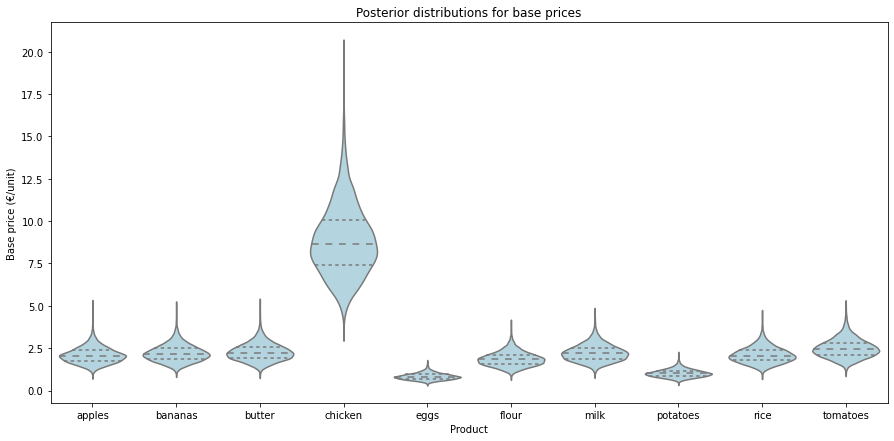

Basic average price for apples: 2.1 (€/unit)
Posterior 98% confidence interval for apples base price:  [1.21823974 3.39266438]

Basic average price for bananas: 2.22 (€/unit)
Posterior 98% confidence interval for bananas base price:  [1.29017203 3.60912048]

Basic average price for butter: 2.28 (€/unit)
Posterior 98% confidence interval for butter base price:  [1.30910765 3.68970054]

Basic average price for chicken: 8.86 (€/unit)
Posterior 98% confidence interval for chicken base price:  [ 5.0191545  14.63251372]

Basic average price for eggs: 0.84 (€/unit)
Posterior 98% confidence interval for eggs base price:  [0.48812594 1.3740776 ]

Basic average price for flour: 1.87 (€/unit)
Posterior 98% confidence interval for flour base price:  [1.08187849 3.0506204 ]

Basic average price for milk: 2.24 (€/unit)
Posterior 98% confidence interval for milk base price:  [1.30380504 3.60976564]

Basic average price for potatoes: 1.03 (€/unit)
Posterior 98% confidence interval for potatoes base pr

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,7))
cols = [f'base_price[{i}]' for i in range(1, 11)]
name = le_product.inverse_transform(range(10))
ax = sns.violinplot(data=posterior_samples[cols],  scale='count', scale_hue=False, 
               color='lightblue', inner='quartile')
ax.set_xticklabels(labels=name)
plt.xlabel('Product')
plt.ylabel('Base price (€/unit)')
plt.title('Posterior distributions for base prices')
plt.show()

# Print out basic average prices
posterior_means = pd.DataFrame(data=np.mean(raw_means, 
                                            axis=1)[:-4].reshape(1, -1), 
                               columns=col_names[1])
for i in range(10):
    col = f"base_price[{i+1}]"
    mean = posterior_means[col][0]
    print(f"Basic average price for {name[i]}: {round(mean, 2)} (€/unit)")
    print(f"Posterior 98% confidence interval for {name[i]} base price:  {np.percentile(posterior_samples[col], [1, 99])}\n")

The basic average price for each product is shown above. Note that since the posterior skews right as seen above, the mean is larger than the median base price. Still, since the range of values are small, they do not differ much from each other. As can be seen in the summary table in the previous section, the difference between the mean and the median stays within just a few cents.

Also notable is that chicken breast has very wide confidence intervals compared to other products. There can be several reasons behind this:

- It might be the case that the area and/or the store brand does not have one multiplier for every item, but rather different multipliers for different products. This can be modeled by letting each area/store brand have its own distribution, from which multipliers for different products are sampled.

- We did not control for the same brands/type of product when recording prices (e.g. organic vs. non-organic product, or recording products of totally different brands at each store), which may lead to a wide confidence interval as seen here.

- We calculated the price per unit with an assumption that price grows linearly with amount of product, which may not be the case, especially for packaged products. For example, one would expect buying one gallon of milk to be cheaper than buying just half a gallon when the price is normalized for volume. If the same product is recorded at different sizes, this would add more variance to the distribution.

### Store & location multipliers

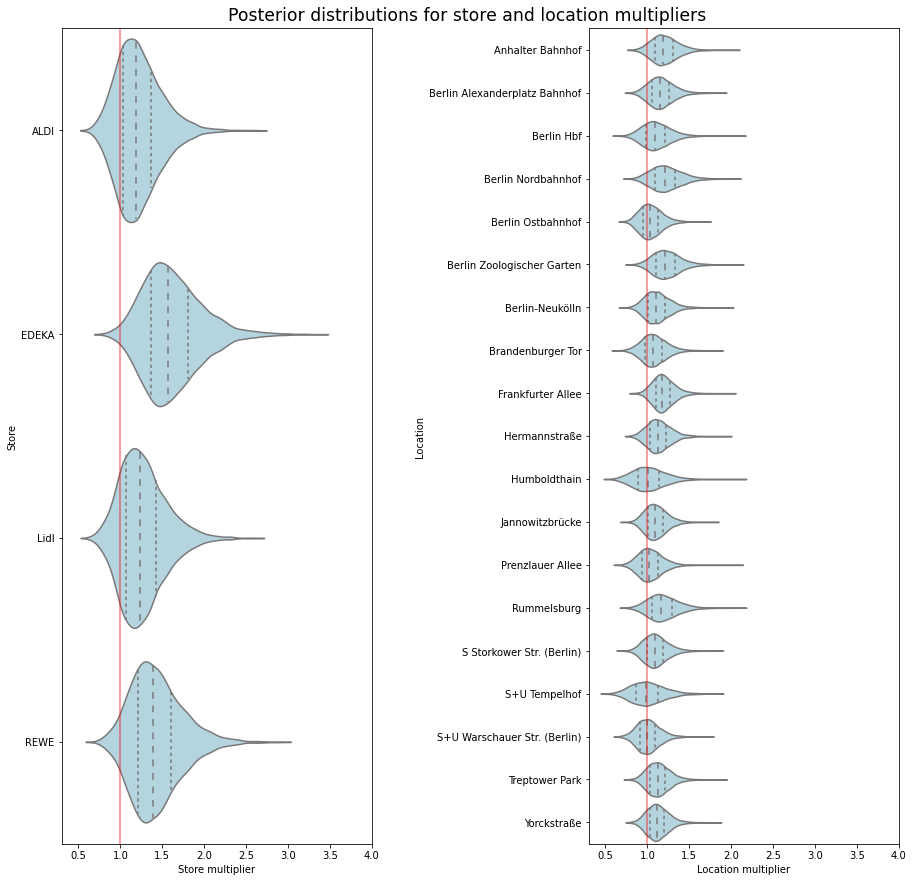

In [8]:
# Plot the figures
pos = 0
# Plot two graphs have the same range to visually compare
# the confidence intervals between the two graphs
f, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True)
for item, n in zip(['store_multiplier', 'location_multiplier'], [n_store, n_loc]):
    cols = [f'{item}[{i}]' for i in range(1, n+1)]
    ax = sns.violinplot(data=posterior_samples[cols], cut=0,
                        scale_hue=False, color='lightblue', inner='quartile', 
                        orient='h', ax=axes[pos], width=0.9)
    
    ax.set_xlim(0.3, 4)
    # Show corresponding store and neighborhood name
    if item=='store_multiplier':
        ax.set_yticklabels(labels=le_store.inverse_transform(range(n)))
    else:
        ax.set_yticklabels(labels=le_location.inverse_transform(range(n)))
    # Plot line indicating value 1 of the center for visual comparison
    ax.axvline(x=1, color='r', alpha=0.5)
    ax.set_xlabel(item.replace('_', ' ').capitalize())
    ax.set_ylabel(item.split('_')[0].capitalize())
    pos += 1
plt.subplots_adjust(wspace=0.7)
plt.suptitle(f"Posterior distributions for store and location multipliers", 
             y=0.9, fontsize='xx-large')
plt.show()

The two plots above show the mean and 98% confidence interval over store and location multipliers. The red horizontal line shows the supposed center of the distribution of these multipliers. Note that this center is the hypothetical theoretical mean of the distribution for all store/location modifiers and not just the ones in the dataset. Considering this, we can see that most stores and locations modify the price up compared to the average.

Comparing store multipliers to location multipliers, we can see that even though there are more locations than store brands (so more data per brand than per neighborhood), the each store multiplier has a much wider distribution. This is another indicate that each store does not has a single modifier, but various modifiers for different product, hence the high variance among the posterior samples in this model. If this is true, the narrower sample distribution of multipliers for each location suggests that stores in the same neighborhood price their product quite similarly to each other.

### Correlation with variation in rental prices

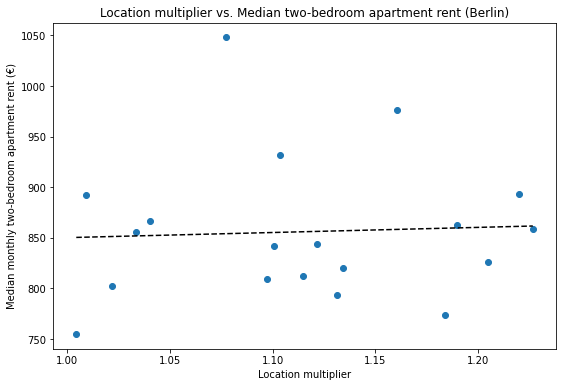

Pearson's r: 0.05, with p-value: 0.84


In [9]:
%matplotlib inline
from scipy import stats

berlin = df['Neighborhood'].unique()
# Berlin rental price retrieved from
# https://www.immobilienscout24.de/content/dam/is24/ibw/dokumente/mietmap-berlin-2017.jpg
berlin_rent_dict = {'Berlin Alexanderplatz Bahnhof': 976,
                    'Berlin Friedrichstraße station': 1044,
                    'Berlin Nordbahnhof': 893,
                    'Berlin Ostbahnhof': 867,
                    'Berlin Potsdamer Platz Bahnhof': 1154,
                    'Berlin Zoologischer Garten': 859,
                    'Berlin-Neukölln': 812,
                    'S+U Tempelhof': 755,
                    'Brandenburger Tor': 1048,
                    'Frankfurter Allee': 863,
                    'Anhalter Bahnhof': 826,
                    'Hermannstraße': 820,
                    'Humboldthain': 802,
                    'Nöldnerplatz': 736,
                    'Prenzlauer Allee': 856,
                    'Berlin Hbf': 932,
                    'Jannowitzbrücke': 842,
                    'Treptower Park': 794,
                    'S+U Warschauer Str. (Berlin)': 892,
                    'Rummelsburg': 774,
                    'S Storkower Str. (Berlin)': 809,
                    'Yorckstraße': 844}
key = le_location.transform(berlin)
berlin_multiplier = [posterior_means[f'location_multiplier[{i+1}]'][0] for i in key]
berlin_rent = [berlin_rent_dict[area] for area in berlin]

coef = np.polyfit(berlin_multiplier, berlin_rent, 1)
poly1d_fn = np.poly1d(coef)
sorted_lst = sorted(berlin_multiplier)

plt.figure(figsize=(9, 6))
plt.plot(sorted_lst, poly1d_fn(sorted_lst), '--k')
plt.scatter(berlin_multiplier, berlin_rent)
plt.title('Location multiplier vs. Median two-bedroom apartment rent (Berlin)')
plt.xlabel('Location multiplier')
plt.ylabel('Median monthly two-bedroom apartment rent (€)')
plt.show()
r, p_val = stats.pearsonr(berlin_multiplier, berlin_rent)
print(f"Pearson's r: {round(r, 2)}, with p-value: {round(p_val, 2)}")

The scatter plot and Pearson's R suggests no significant correlation between the location multipler and rental price. Nonetheless, it might worth calculating and ploting the confidence intervals of the linear regression to see know how confident we are in the result.